# Table of Contents
- 解析対象ファイル
- データの確認
- データ加工
- 分析
- 独立性の検定
- Appendix（高度なグラフ描画）

## 解析対象ファイル
* user_login.csv: サービスAのユーザーlogin時間(4月分)
    - user_id: user id
    - timestamp: login time
* event_entry_users.csv:イベント参加ユーザーリスト 
    - user_id: user id
    - timestamp: event entry time
* item_purchase_log.csv: アイテム購買履歴
    - user_id: user id
    - item_id: item id
    - timestamp: item purchased time

# データの確認

In [1]:
import datetime
import numpy as np
import pandas as pd
import pandas_profiling
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
user_login_df = pd.read_csv('user_login.csv')
user_login_df = user_login_df.rename(columns={'timestamp': 'timestamp_login'})

event_entry_df = pd.read_csv('event_entry_users.csv')
event_entry_df = event_entry_df.rename(columns={'timestamp': 'timestamp_event_entry'})

item_purchase_df = pd.read_csv('item_purchase_log.csv')
item_purchase_df = item_purchase_df.rename(columns={'timestamp': 'timestamp_item_purchase'})

In [ ]:
# サービスAのユーザーlogin時間(4月分)
pandas_profiling.ProfileReport(user_login_df)

In [4]:
# 4月の最多ログインユーザーをサンプル確認
user_login_df['user_id'].value_counts()[:5]

u00004565    43
u00000941    42
u00007779    42
u00007006    41
u00001872    41
Name: user_id, dtype: int64

1日に何度かログインしている人（≒30回以上ログインしている人）がいることを確認

In [5]:
user_login_df.head()

,user_id,timestamp_login
0,u00005154,2016-04-01 00:01:03.90
1,u00000381,2016-04-01 00:01:18.67
2,u00004355,2016-04-01 00:01:23.34
3,u00001105,2016-04-01 00:01:25.70
4,u00004565,2016-04-01 00:01:38.57


In [6]:
# タイプスタンプから日にちだけ抽出して列作成
user_login_df['timestamp_login'] = pd.to_datetime(user_login_df['timestamp_login'], format='%Y-%m-%d %H:%M:%S.%f')
user_login_df['login_date'] = user_login_df['timestamp_login'].dt.date
user_login_df.head()

,user_id,timestamp_login,login_date
0,u00005154,2016-04-01 00:01:03.900,2016-04-01
1,u00000381,2016-04-01 00:01:18.670,2016-04-01
2,u00004355,2016-04-01 00:01:23.340,2016-04-01
3,u00001105,2016-04-01 00:01:25.700,2016-04-01
4,u00004565,2016-04-01 00:01:38.570,2016-04-01


In [7]:
# インデックス設定
user_login_df.set_index('user_id', drop=False, inplace=True)
user_login_df.head()

,user_id,timestamp_login,login_date
user_id,,,
u00005154,u00005154,2016-04-01 00:01:03.900,2016-04-01
u00000381,u00000381,2016-04-01 00:01:18.670,2016-04-01
u00004355,u00004355,2016-04-01 00:01:23.340,2016-04-01
u00001105,u00001105,2016-04-01 00:01:25.700,2016-04-01
u00004565,u00004565,2016-04-01 00:01:38.570,2016-04-01


In [8]:
# 2列で集約した後、1列目の大きな集約単位で要素の数を数える。
# 2列目の細かい集約単位で要素の数を変える場合は、.count()を外す。
login_days = user_login_df.groupby(['user_id', 'login_date']).size().count(level='user_id')
login_days.head()

/Users/ikki/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


user_id
u00000001    29
u00000002    28
u00000003     8
u00000004    14
u00000005     4
dtype: int64

In [9]:
# シリーズ型をfor文で回して、インデックスと値を処理したいときの書き方
for index, value in login_days.iteritems():
    user_login_df.at[index, 'login_days'] = value
user_login_df.reset_index(drop=True, inplace=True)

user_login_df.head()

,user_id,timestamp_login,login_date,login_days
0,u00005154,2016-04-01 00:01:03.900,2016-04-01,30.0
1,u00000381,2016-04-01 00:01:18.670,2016-04-01,21.0
2,u00004355,2016-04-01 00:01:23.340,2016-04-01,29.0
3,u00001105,2016-04-01 00:01:25.700,2016-04-01,29.0
4,u00004565,2016-04-01 00:01:38.570,2016-04-01,30.0


In [10]:
# ある列の値を比較して、値を付与する書き方
user_login_df['not_active'] = np.where(user_login_df['login_days'] <= 10, 1, 0)
user_login_df['active'] = np.where((10 < user_login_df['login_days']) & (user_login_df['login_days'] < 21), 1, 0)
user_login_df['most_active'] = np.where(21 <= user_login_df['login_days'], 1, 0)
user_login_df.head()

,user_id,timestamp_login,login_date,login_days,not_active,active,most_active
0,u00005154,2016-04-01 00:01:03.900,2016-04-01,30.0,0,0,1
1,u00000381,2016-04-01 00:01:18.670,2016-04-01,21.0,0,0,1
2,u00004355,2016-04-01 00:01:23.340,2016-04-01,29.0,0,0,1
3,u00001105,2016-04-01 00:01:25.700,2016-04-01,29.0,0,0,1
4,u00004565,2016-04-01 00:01:38.570,2016-04-01,30.0,0,0,1


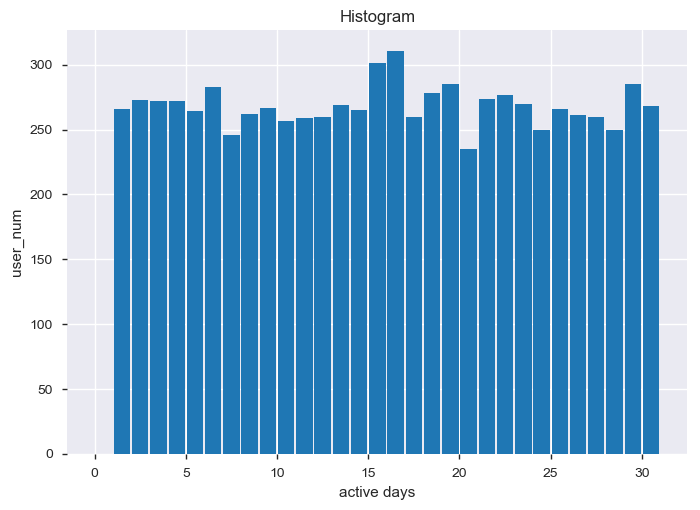

In [11]:
# サービス利用日数を可視化
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(login_days, range(0, 32), rwidth=0.9)
ax.set_title('Histogram')
ax.set_xlabel('active days')
ax.set_ylabel('user_num')
plt.savefig('./AprilActiveDays.png', dpi=300, bbox_inches='tight')

だいたい一様に分布している様子。

In [12]:
# 2回参加した人もいる。
print('2回以上参加した人数', event_entry_df.duplicated(subset='user_id').value_counts()[True])

# サンプル確認
event_entry_df.loc[event_entry_df['user_id']=='u00005434']

2回以上参加した人数 255


,user_id,timestamp_event_entry
738,u00005434,2016-05-01 09:11:11
1583,u00005434,2016-05-01 19:29:36


In [13]:
# 何回イベントに参加したかカラム追加
event_entry_df.set_index('user_id', drop=False, inplace=True)

for index, value in event_entry_df['user_id'].value_counts().iteritems():
    event_entry_df.at[index, 'event_entry_num'] = value

event_entry_df.reset_index(drop=True, inplace=True)

In [14]:
# 2回参加した人の重複削除
event_entry_df.drop_duplicates(subset='user_id', inplace=True)

In [15]:
# アイテム購買履歴をイベント効果範囲で絞り込み
item_purchase_df['timestamp_item_purchase'] = pd.to_datetime(item_purchase_df['timestamp_item_purchase'], format='%Y-%m-%d %H:%M:%S.%f')
item_purchase_df['item_purchase_date'] = item_purchase_df['timestamp_item_purchase'].dt.date
print(item_purchase_df['item_purchase_date'].value_counts())  # イベント開催日以降の購入が多い
item_purchase_df = item_purchase_df.loc[item_purchase_df['item_purchase_date'] <= datetime.date(2016, 5, 8)]

2016-05-03    159
2016-05-05    158
2016-05-04    145
2016-05-07    144
2016-05-02    130
2016-05-06    127
2016-05-08     87
2016-05-01     83
2016-05-13      4
2016-05-10      2
2016-05-11      2
2016-05-12      1
2016-05-09      1
Name: item_purchase_date, dtype: int64


In [16]:
# 何回買ったかカラム追加
item_purchase_df.set_index('user_id', drop=False, inplace=True)

for index, value in item_purchase_df['user_id'].value_counts().iteritems():
    item_purchase_df.at[index, 'item_purchase_num'] = value

item_purchase_df.reset_index(drop=True, inplace=True)

assert len(item_purchase_df.loc[item_purchase_df['item_purchase_num'] == 2]['user_id'].value_counts()) == 34

In [17]:
# 2回以上購入した人の重複削除
item_purchase_drop_duplicated_df = item_purchase_df.drop_duplicates(subset='user_id')
assert 1033 - 34 == len(item_purchase_drop_duplicated_df)

In [18]:
# 重複確認：ユーザーlogin時間とイベント参加ユーザーリストのuser_id
print('Unique user in user_login_df:', len(user_login_df.user_id.unique()))
print('Unique user in event_entry_df:', len(event_entry_df.user_id.unique()))
print('Common users in both:', len(set(user_login_df.user_id.unique()) & set(event_entry_df.user_id.unique())))

Unique user in user_login_df: 8046
Unique user in event_entry_df: 3779
Common users in both: 3779


# データ加工

In [19]:
# ユーザーlogin時間とイベント参加ユーザーリストを結合して、イベント参加有無を表すフラグを付与
master_df = pd.merge(user_login_df, event_entry_df, on='user_id', how='left')
master_df['event_entry_flag'] = np.where(master_df['timestamp_event_entry'].isnull(), 0, 1)

In [20]:
# アイテム購買記録を結合して、アイテム購買有無を表すフラグを付与
master_df = pd.merge(master_df, item_purchase_drop_duplicated_df, on='user_id', how='left')
master_df['item_purchase_flag'] = np.where(master_df['timestamp_item_purchase'].isnull(), 0, 1)

In [21]:
# 型変換
master_df['login_days'] = master_df['login_days'].astype(np.int8)
master_df['event_entry_num'] = master_df['event_entry_num'].fillna(0.0).astype(np.int8)
master_df['item_purchase_num'] = master_df['item_purchase_num'].fillna(0.0).astype(np.int8)
master_df['timestamp_login'] = pd.to_datetime(master_df['timestamp_login'], format='%Y-%m-%d %H:%M:%S.%f')
master_df['login_date'] = pd.to_datetime(master_df['login_date'], format='%Y-%m-%d %H:%M:%S.%f')
master_df['timestamp_event_entry'] = pd.to_datetime(master_df['timestamp_event_entry'], format='%Y-%m-%d %H:%M:%S.%f')
master_df['timestamp_item_purchase'] = pd.to_datetime(master_df['timestamp_item_purchase'], format='%Y-%m-%d %H:%M:%S.%f')
master_df['item_purchase_date'] = pd.to_datetime(master_df['item_purchase_date'], format='%Y-%m-%d %H:%M:%S.%f')

In [22]:
master_df.head()

,user_id,timestamp_login,login_date,login_days,not_active,active,most_active,timestamp_event_entry,event_entry_num,event_entry_flag,item_id,timestamp_item_purchase,item_purchase_date,item_purchase_num,item_purchase_flag
0,u00005154,2016-04-01 00:01:03.900,2016-04-01,30,0,0,1,2016-05-02 08:23:51,1,1,NaN,NaT,NaT,0,0
1,u00000381,2016-04-01 00:01:18.670,2016-04-01,21,0,0,1,NaT,0,0,NaN,NaT,NaT,0,0
2,u00004355,2016-04-01 00:01:23.340,2016-04-01,29,0,0,1,NaT,0,0,NaN,NaT,NaT,0,0
3,u00001105,2016-04-01 00:01:25.700,2016-04-01,29,0,0,1,2016-05-01 14:09:58,1,1,NaN,NaT,NaT,0,0
4,u00004565,2016-04-01 00:01:38.570,2016-04-01,30,0,0,1,2016-05-01 08:09:35,1,1,NaN,NaT,NaT,0,0


# 分析

In [23]:
# user_idの重複削除
analysis_df = master_df.drop_duplicates(subset='user_id')

In [24]:
# 集約
analysis_df = analysis_df[['not_active', 'active', 'most_active', 'event_entry_flag', 'item_purchase_flag']]
analysis_df.sort_values(['event_entry_flag', 'item_purchase_flag'], inplace=True)
analysis_agg_df = analysis_df.groupby([analysis_df['event_entry_flag'], analysis_df['item_purchase_flag']]).sum()
analysis_agg_df

not_active  active  most_active
event_entry_flag item_purchase_flag                                 
0                0                         1694    1327          592
                 1                          425     208           21
1                0                          432    1042         1960
                 1                          111     146           88

In [25]:
# 割合表示
analysis_agg_pct_df = analysis_agg_df / analysis_agg_df.sum() * 100
analysis_agg_pct_df

not_active     active  most_active
event_entry_flag item_purchase_flag                                    
0                0                    63.636364  48.733015    22.247275
                 1                    15.965440   7.638634     0.789177
1                0                    16.228400  38.266618    73.656520
                 1                     4.169797   5.361733     3.307027

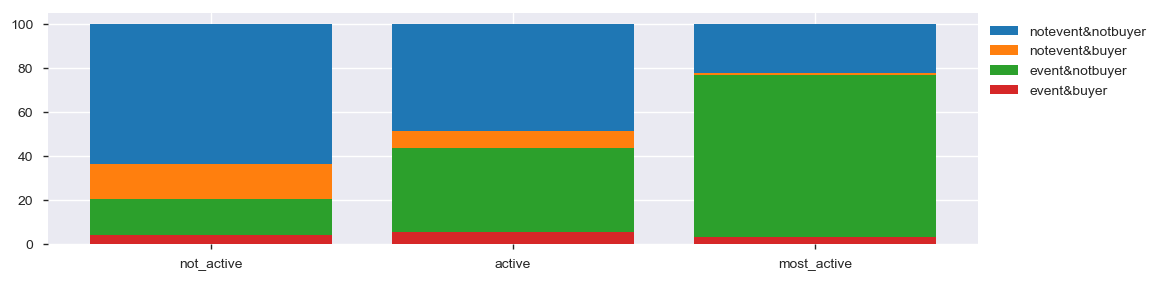

In [26]:
# 棒グラフに描画する
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)

x = np.arange(1, 4)
labels = ['not_active', 'active', 'most_active']

y4 = analysis_agg_pct_df.iloc[:, :].sum().tolist()
y3 = analysis_agg_pct_df.iloc[1:4, :].sum().tolist()
y2 = analysis_agg_pct_df.iloc[2:4, :].sum().tolist()
y1 = analysis_agg_pct_df.iloc[3, :].tolist()

ax.bar(x, y4, tick_label=labels, label='notevent&notbuyer') 
ax.bar(x, y3, tick_label=labels, label='notevent&buyer') 
ax.bar(x, y2, tick_label=labels, label='event&notbuyer')
ax.bar(x, y1, tick_label=labels, label='event&buyer')
ax.legend(bbox_to_anchor=(1, 1))

plt.savefig('./BarGraphAnalysis.png', dpi=300, bbox_inches='tight')

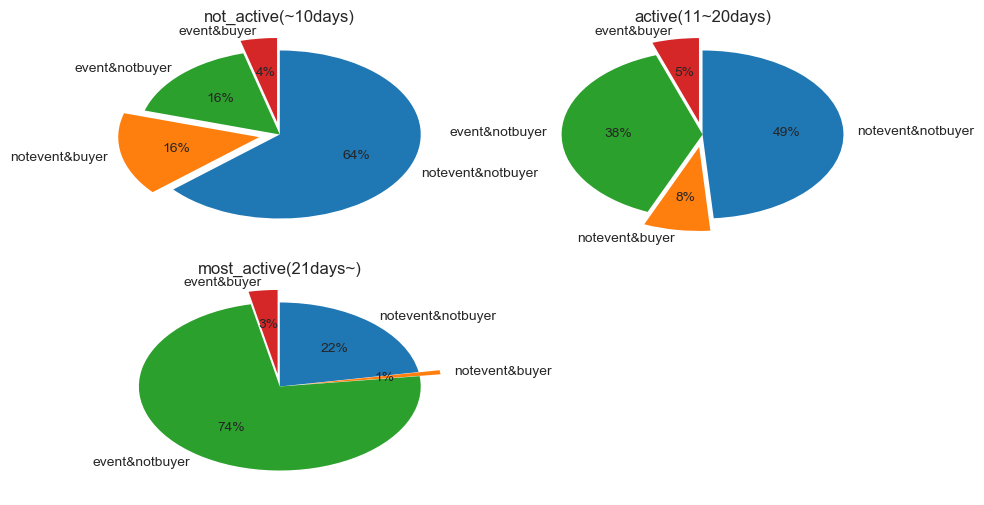

In [27]:
# 円グラフの描画
fig = plt.figure(figsize=(10,6))
ax1= fig.add_subplot(221)
ax2= fig.add_subplot(222)
ax3= fig.add_subplot(223)

axes = [ax1, ax2, ax3]
labels = ['notevent&notbuyer', 'notevent&buyer', 'event&notbuyer', 'event&buyer']
titles = ['not_active(~10days)', 'active(11~20days)', 'most_active(21days~)']

for i in range(0, 3):
    sizes = analysis_agg_pct_df.iloc[:, i].tolist()
    axes[i].pie(sizes, labels=labels, startangle=90, counterclock=False, explode=(0, 0.15, 0, 0.15), autopct='%1.0f%%')
    axes[i].set_title(titles[i])

plt.savefig('./PieChartsAnalysis.png', dpi=300, bbox_inches='tight')

In [28]:
print('イベント参加率（%）{:2.2f}%'.format(len(event_entry_df.user_id.unique()) / len(user_login_df.user_id.unique()) * 100))
print('購買率（%）{:2.2f}%'.format(len(item_purchase_df.user_id.unique()) / len(user_login_df.user_id.unique()) * 100))

イベント参加率（%）46.97%
購買率（%）12.42%


In [29]:
# 細分化
notevent_notbuyer = analysis_df.loc[(analysis_df['event_entry_flag'] == 0) & (analysis_df['item_purchase_flag'] == 0)]
notevent_buyer = analysis_df.loc[(analysis_df['event_entry_flag'] == 0) & (analysis_df['item_purchase_flag'] == 1)]
event_notbuyer = analysis_df.loc[(analysis_df['event_entry_flag'] == 1) & (analysis_df['item_purchase_flag'] == 0)]
event_buyer = analysis_df.loc[(analysis_df['event_entry_flag'] == 1) & (analysis_df['item_purchase_flag'] == 1)]

In [30]:
# イベント参加者の切り口で再結合
event_df = pd.concat([event_notbuyer, event_buyer])
if len(event_df['event_entry_flag'].unique()) == 1:
    event_df.drop(['event_entry_flag'], axis=1, inplace=True)
assert event_df.shape == (3779, 4), '「イベント参加」のユーザー数がおかしい'

event_agg_df = event_df.groupby(event_df['item_purchase_flag']).sum()
event_agg_df

,not_active,active,most_active
item_purchase_flag,,,
0,432,1042,1960
1,111,146,88


In [31]:
# 割合表示
event_agg_df / event_agg_df.sum() * 100

,not_active,active,most_active
item_purchase_flag,,,
0,79.558011,87.710438,95.703125
1,20.441989,12.289562,4.296875


# 独立性検定

カイ二乗検定  
帰無仮説$H_0$: 「アイテム購入」と「サービス利用頻度」は独立である（関係がない）」  
対立仮説$H_1$: 「アイテム購入」と「サービス利用頻度」は独立ではない（関係がある）」

有意水準を0.05とする。  
自由度は(3-1)*(2-1)の3。  
棄却域7.81  

In [32]:
event_data = np.array(event_agg_df)
result = stats.chi2_contingency(event_data)

print('カイ二乗の統計量：{:3.3f}'.format(result[0]))
print('p値：{:3.3f}'.format(result[1]))

カイ二乗の統計量：155.717
p値：0.000


p値が有意水準を下回ったため、帰無仮説$H_0$を棄却する。  
（対立仮説$H_1$『「アイテム購入」と「サービス利用頻度」は独立ではない（関係がある）』を支持する。）

# Appendix

In [33]:
analysis_df = master_df.drop_duplicates(subset='user_id')
notevent_notbuyer_analysis_df = analysis_df.loc[(analysis_df['event_entry_flag'] == 0) & (analysis_df['item_purchase_flag'] == 0)]
notevent_buyer_analysis_df = analysis_df.loc[(analysis_df['event_entry_flag'] == 0) & (analysis_df['item_purchase_flag'] == 1)]
event_notbuyer_analysis_df = analysis_df.loc[(analysis_df['event_entry_flag'] == 1) & (analysis_df['item_purchase_flag'] == 0)]
event_buyer_analysis_df = analysis_df.loc[(analysis_df['event_entry_flag'] == 1) & (analysis_df['item_purchase_flag'] == 1)]

In [34]:
buyer_analysis_df = pd.concat([notevent_buyer_analysis_df, event_buyer_analysis_df])

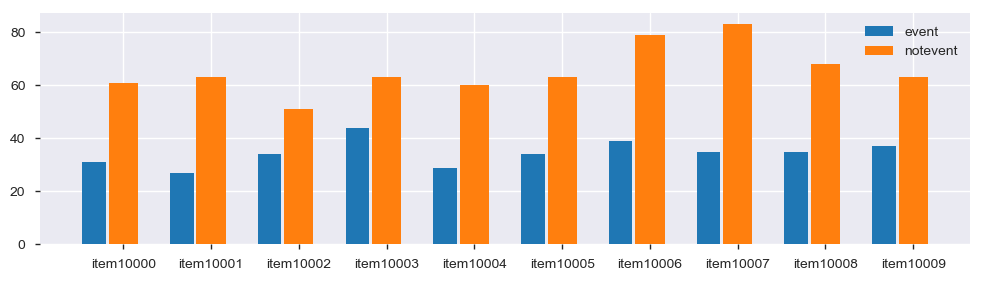

In [35]:
# 棒グラフ
y1 = buyer_analysis_df.loc[buyer_analysis_df['event_entry_flag'] == 1]['item_id'].value_counts().sort_index()
y2 = buyer_analysis_df.loc[buyer_analysis_df['event_entry_flag'] == 0]['item_id'].value_counts().sort_index()

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)

w = 1
x = np.arange(1, 11) * 3
labels = ['item10000', 'item10001', 'item10002', 'item10003', 'item10004', 'item10005', 'item10006', 'item10007', 'item10008', 'item10009']
ax.bar(x, y1, tick_label=labels, label='event') 
ax.bar(x+w, y2, width=w, tick_label=labels, label='notevent')
ax.legend(loc='upper right')

plt.savefig('./ItemAnalysis_BarGraph.png', dpi=300, bbox_inches='tight')

イベントしたことでitem10002や10003の購買底上げ効果があるかもしれない。

In [36]:
event_item_purchase_num_df = event_buyer_analysis_df.groupby(event_buyer_analysis_df['item_purchase_num']).sum()
event_item_purchase_num_df.drop(['login_days', 'event_entry_flag', 'event_entry_num', 'item_purchase_flag'], axis=1, inplace=True)

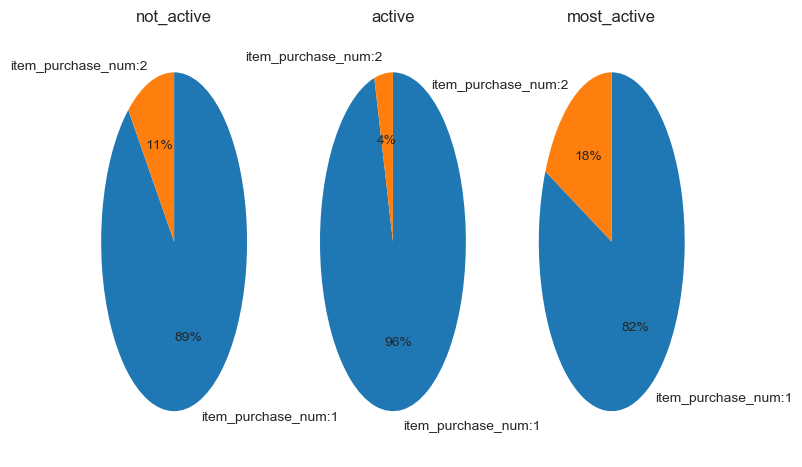

In [37]:
# 円グラフの描画
fig, axes = plt.subplots(1, 3)

labels = ['item_purchase_num:1', 'item_purchase_num:2']
titles = ['not_active', 'active', 'most_active']

y1_pct = event_item_purchase_num_df.iloc[0] / event_item_purchase_num_df.sum()
y2_pct = event_item_purchase_num_df.iloc[1] / event_item_purchase_num_df.sum()
y_pct = np.array(pd.concat([y1_pct, y2_pct], axis=1))

for i in range(0, 3):
    sizes = y_pct[i].tolist()
    axes[i].pie(sizes, labels=labels, startangle=90, counterclock=False, autopct='%1.0f%%')
    axes[i].set_title(titles[i])

plt.savefig('./ItemPurchaseNumAnalysis.png', dpi=300, bbox_inches='tight')

eventに参加したmost_activeは2回買う人の割合は多く、使いこなしている、と言える。  